In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Veri yükleme
df = pd.read_csv("gym_members_exercise_tracking.csv")
df = df.dropna()
df.reset_index(drop=True, inplace=True)

print("="*70)
print("EXPERIENCE LEVEL PREDICTION MODEL")
print("="*70)
print(f"\nVeri seti boyutu: {df.shape}")

EXPERIENCE LEVEL PREDICTION MODEL

Veri seti boyutu: (973, 15)


In [30]:
# Target analizi
print("\nExperience Level Dağılımı:")
print(df["Experience_Level"].value_counts().sort_index())
print(f"\nExperience Level oranları:")
print(df["Experience_Level"].value_counts(normalize=True).sort_index())


Experience Level Dağılımı:
Experience_Level
1    376
2    406
3    191
Name: count, dtype: int64

Experience Level oranları:
Experience_Level
1    0.386434
2    0.417266
3    0.196300
Name: proportion, dtype: float64


In [31]:
# FEATURE ENGINEERING
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)

df["HR_per_minute"] = df["Avg_BPM"] / (df["Session_Duration (hours)"] * 60)
df["Intensity_per_Weight"] = df["Calories_Burned"] / df["Weight (kg)"]
df["HRR"] = df["Max_BPM"] - df["Resting_BPM"]
df["Efficiency"] = df["Calories_Burned"] / df["Avg_BPM"]
df["Anaerobic_Index"] = (df["Max_BPM"] - df["Avg_BPM"]) / df["Resting_BPM"]
df["BPM_Variance_Rest"] = (df["Avg_BPM"] - df["Resting_BPM"]) ** 2
df["Heart_Instability"] = abs(df["Max_BPM"] - df["Avg_BPM"]) / df["Max_BPM"]
df["Calories_per_Hour"] = df["Calories_Burned"] / df["Session_Duration (hours)"]
df["Heart_Efficiency"] = df["Calories_Burned"] / df["HRR"]
df["BMI_Category"] = pd.cut(df["BMI"], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3]).astype(int)
df["Age_Group"] = pd.cut(df["Age"], bins=[0, 25, 35, 45, 100], labels=[0, 1, 2, 3]).astype(int)


FEATURE ENGINEERING


In [32]:
# Deneyim ile ilgili ek feature'lar
df["Workout_Intensity"] = df["Calories_Burned"] * df["Max_BPM"] / 1000
df["Performance_Score"] = df["Calories_Burned"] * df["Workout_Frequency (days/week)"]
df["Fitness_Level"] = df["HRR"] / df["Resting_BPM"]
df["Training_Load"] = df["Session_Duration (hours)"] * df["Workout_Frequency (days/week)"] * df["Avg_BPM"]

print(f"Toplam {len([col for col in df.columns if col in ['HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency', 'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability', 'Calories_per_Hour', 'Heart_Efficiency', 'BMI_Category', 'Age_Group', 'Workout_Intensity', 'Performance_Score', 'Fitness_Level', 'Training_Load']])} yeni feature oluşturuldu")


Toplam 15 yeni feature oluşturuldu


In [33]:
# Label Encoding
le_gender = LabelEncoder()
le_workout = LabelEncoder()

df["Gender_Code"] = le_gender.fit_transform(df["Gender"])
df["Workout_Code"] = le_workout.fit_transform(df["Workout_Type"])


In [34]:
# Feature Selection - Experience Level'ı ÇIKARIYORUZ (target olacak)
feature_cols = [
    'Age', 'Gender_Code', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Workout_Frequency (days/week)',
    'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Code', 'BMI',
    'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability',
    'Calories_per_Hour', 'Heart_Efficiency', 'BMI_Category', 'Age_Group',
    'Workout_Intensity', 'Performance_Score', 'Fitness_Level', 'Training_Load'
]

X = df[feature_cols]
y = df['Experience_Level']

print(f"\nFeature sayısı: {X.shape[1]}")
print(f"Target (Experience Level): {y.name}")



Feature sayısı: 29
Target (Experience Level): Experience_Level


In [35]:
#split the data as train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Train set: (681, 29)
Test set: (292, 29)


In [36]:
# Class imbalance kontrol
print("\nTrain set dağılımı:")
print(pd.Series(y_train).value_counts().sort_index())


Train set dağılımı:
Experience_Level
1    263
2    284
3    134
Name: count, dtype: int64


In [37]:
# SMOTE (opsiyonel - zaten dengeli ama deneyelim)
use_smote = False  # Gerekirse True yap

if use_smote:
    sm = SMOTE(random_state=42, k_neighbors=5)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print(f"\nSMOTE sonrası train set: {X_train_res.shape}")
    print("SMOTE sonrası dağılım:")
    print(pd.Series(y_train_res).value_counts().sort_index())
else:
    X_train_res, y_train_res = X_train, y_train
    print("\nSMOTE kullanılmıyor (veri zaten dengeli)")


SMOTE kullanılmıyor (veri zaten dengeli)


In [38]:
# Random Forest Model
print("\n" + "="*70)
print("RANDOM FOREST MODEL EĞİTİMİ")
print("="*70)

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

print("Model eğitiliyor...")
rf.fit(X_train_res, y_train_res)

# Tahmin
y_pred = rf.predict(X_test)

# SONUÇLAR
print("\n" + "="*70)
print("MODEL PERFORMANSI")
print("="*70)

accuracy = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Mean Absolute Error: {mae:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Level 1', 'Level 2', 'Level 3']))



RANDOM FOREST MODEL EĞİTİMİ
Model eğitiliyor...

MODEL PERFORMANSI

Accuracy: 0.8836 (88.36%)
Mean Absolute Error: 0.1164

Classification Report:
              precision    recall  f1-score   support

     Level 1       0.90      0.79      0.84       113
     Level 2       0.82      0.92      0.87       122
     Level 3       1.00      1.00      1.00        57

    accuracy                           0.88       292
   macro avg       0.91      0.90      0.90       292
weighted avg       0.89      0.88      0.88       292



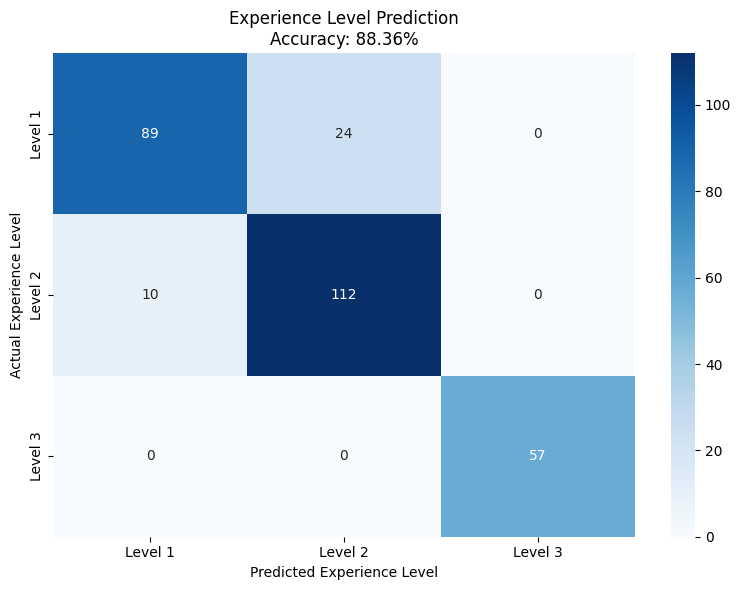

In [39]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Level 1', 'Level 2', 'Level 3'],
            yticklabels=['Level 1', 'Level 2', 'Level 3'])
plt.title(f'Experience Level Prediction\nAccuracy: {accuracy:.2%}')
plt.xlabel('Predicted Experience Level')
plt.ylabel('Actual Experience Level')
plt.tight_layout()
plt.show()

In [40]:
# Feature Importance
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 15 En Önemli Features:")
for i in range(min(15, len(indices))):
    print(f"{i+1}. {X.columns[indices[i]]}: {importances[indices[i]]:.4f}")


FEATURE IMPORTANCE ANALYSIS

Top 15 En Önemli Features:
1. Training_Load: 0.1496
2. Performance_Score: 0.1408
3. Session_Duration (hours): 0.1370
4. Fat_Percentage: 0.1159
5. Workout_Frequency (days/week): 0.1042
6. Efficiency: 0.0618
7. HR_per_minute: 0.0507
8. Calories_Burned: 0.0389
9. Workout_Intensity: 0.0313
10. Heart_Efficiency: 0.0269
11. Intensity_per_Weight: 0.0148
12. Calories_per_Hour: 0.0123
13. Heart_Instability: 0.0123
14. Water_Intake (liters): 0.0116
15. Anaerobic_Index: 0.0107


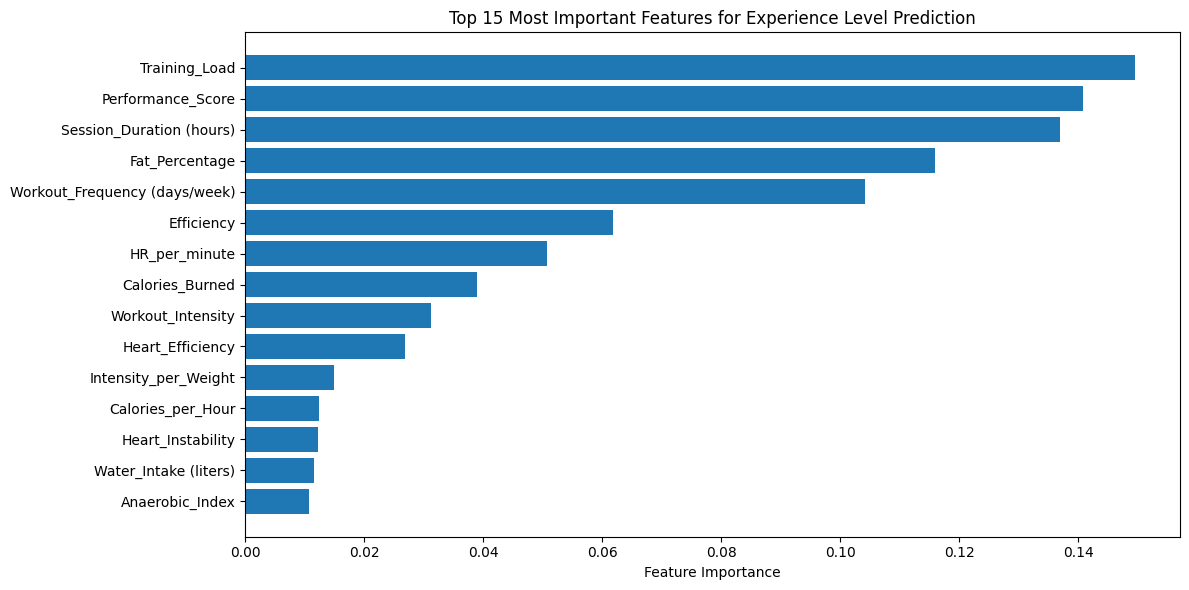

In [41]:
# Feature Importance Visualization
plt.figure(figsize=(12, 6))
top_n = 15
plt.barh(range(top_n), importances[indices[:top_n]])
plt.yticks(range(top_n), [X.columns[i] for i in indices[:top_n]])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features for Experience Level Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [42]:
# Cross-Validation
print("\n" + "="*70)
print("CROSS-VALIDATION (5-Fold)")
print("="*70)

cv_scores = cross_val_score(rf, X_train_res, y_train_res, cv=5, scoring='accuracy')
print(f"\nFold Accuracies: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


CROSS-VALIDATION (5-Fold)

Fold Accuracies: [0.88321168 0.875      0.86764706 0.88235294 0.83088235]
Mean CV Accuracy: 0.8678 (+/- 0.0193)


In [43]:
# Hyperparameter Tuning (GridSearchCV)
print("\n" + "="*70)
print("HYPERPARAMETER TUNING")
print("="*70)

param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [15, 20, 25],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

print("GridSearchCV başlatılıyor... (Bu birkaç dakika sürebilir)")
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_res, y_train_res)

print(f"\nEn iyi parametreler: {grid_search.best_params_}")
print(f"En iyi CV skoru: {grid_search.best_score_:.4f}")


HYPERPARAMETER TUNING
GridSearchCV başlatılıyor... (Bu birkaç dakika sürebilir)
Fitting 3 folds for each of 162 candidates, totalling 486 fits

En iyi parametreler: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
En iyi CV skoru: 0.8840


In [44]:
# En iyi modelle test
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
best_accuracy = accuracy_score(y_test, y_pred_best)

print(f"Test seti accuracy (en iyi model): {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

Test seti accuracy (en iyi model): 0.8836 (88.36%)


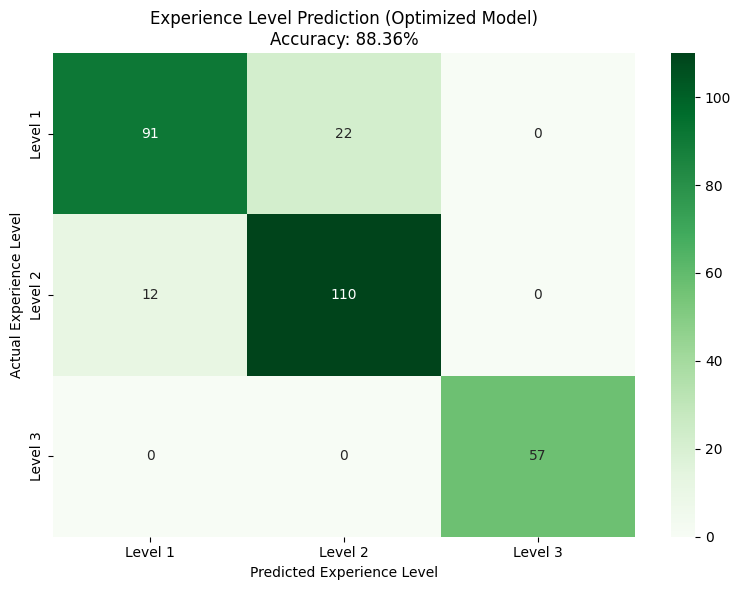

In [45]:
# Final Confusion Matrix (En iyi model)
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Level 1', 'Level 2', 'Level 3'],
            yticklabels=['Level 1', 'Level 2', 'Level 3'])
plt.title(f'Experience Level Prediction (Optimized Model)\nAccuracy: {best_accuracy:.2%}')
plt.xlabel('Predicted Experience Level')
plt.ylabel('Actual Experience Level')
plt.tight_layout()
plt.show()

In [46]:
# Yanlış tahminleri analiz et
print("\n" + "="*70)
print("HATA ANALİZİ")
print("="*70)

errors = y_test != y_pred_best
error_df = X_test[errors].copy()
error_df['Actual'] = y_test[errors].values
error_df['Predicted'] = y_pred_best[errors]
error_df['Error'] = abs(error_df['Actual'] - error_df['Predicted'])

print(f"\nToplam hatalı tahmin: {errors.sum()} / {len(y_test)}")
print(f"Hata oranı: {errors.sum()/len(y_test)*100:.2f}%")

if errors.sum() > 0:
    print("\nHata dağılımı:")
    print(error_df['Error'].value_counts().sort_index())
    print("\nEn çok karıştırılan tahminler:")
    print(error_df.groupby(['Actual', 'Predicted']).size().sort_values(ascending=False))

print("\n" + "="*70)
print("MODEL HAZIR!")
print("="*70)
print(f"Final Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_best):.4f}")


HATA ANALİZİ

Toplam hatalı tahmin: 34 / 292
Hata oranı: 11.64%

Hata dağılımı:
Error
1    34
Name: count, dtype: int64

En çok karıştırılan tahminler:
Actual  Predicted
1       2            22
2       1            12
dtype: int64

MODEL HAZIR!
Final Accuracy: 0.8836 (88.36%)
Mean Absolute Error: 0.1164
